In [1]:
# Install opendatadets to download the data
!pip install opendatasets --upgrade --quiet

In [2]:
# Used opendatasets to load our dataset.
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vishalpahuja
Your Kaggle Key: ··········


100%|██████████| 96.0M/96.0M [00:01<00:00, 59.9MB/s]


The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [ ]:
import os
DATA_DIR = '/content/cats-faces-64x64-for-generative-models/cats'
print(os.listdir(DATA_DIR))

In [5]:
print(os.listdir(DATA_DIR)[:10])

['5560.jpg', '10848.jpg', '8347.jpg', '1714.jpg', '11673.jpg', '4701.jpg', '10995.jpg', '1020.jpg', '5181.jpg', '1028.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Created helper functions to denormalize the image tensors and display some sample images from a training batch.

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

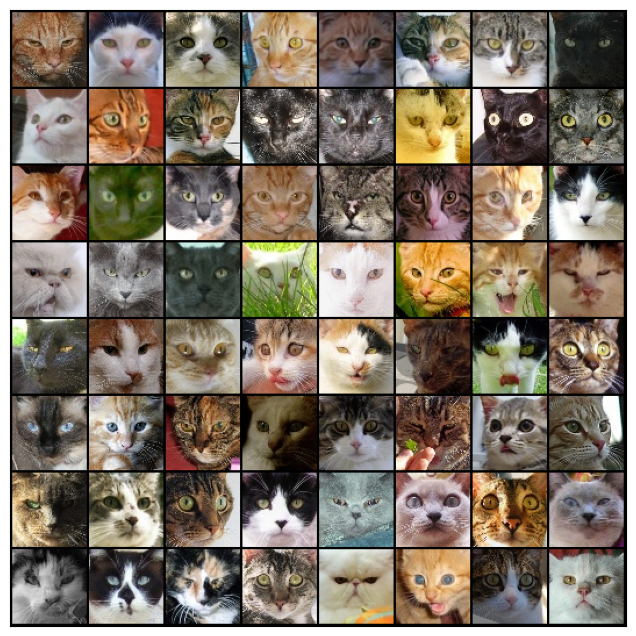

In [12]:
show_batch(train_dl)


I have defined a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. I have used a convolutional neural networks (CNN) which outputs a single number output for every image.I have used stride of 2 to progressively reduce the size of the output feature map.



In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),


    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

Used the TanH activation function for the output layer of the generator.
Since the outputs of the TanH activation lie in the range `[-1,1]`, i have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


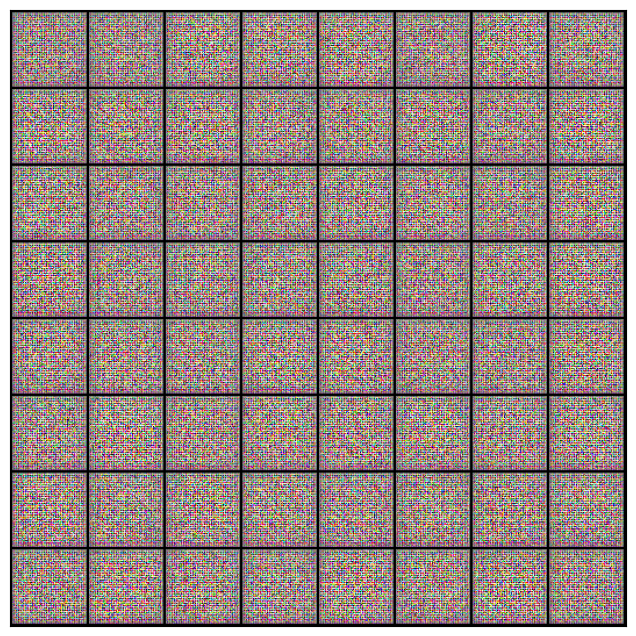

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

The output from the generator is basically random noise, since we haven't trained it yet.

Moving the generator to the chosen device.

In [22]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, I have used the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.



In [23]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training


- Generated a batch of images using the generator, pass the into the discriminator.

- Calculated the loss by setting the target labels to 1.

- Used the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [24]:
def train_generator(opt_g):

    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


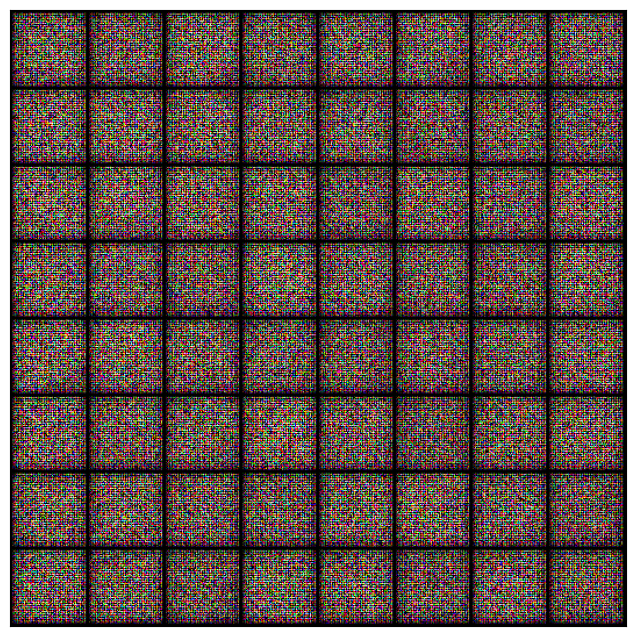

In [29]:
save_samples(0, fixed_latent)

In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))


        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

**Training the model**


In [33]:
lr = 0.0002
epochs = 100

In [34]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.0119, loss_d: 0.5656, real_score: 0.9279, fake_score: 0.3654
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.1011, loss_d: 0.3100, real_score: 0.9286, fake_score: 0.1981
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 6.1049, loss_d: 1.3293, real_score: 0.8242, fake_score: 0.6052
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.6592, loss_d: 0.4059, real_score: 0.9845, fake_score: 0.3059
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.5546, loss_d: 0.3168, real_score: 0.7953, fake_score: 0.0804
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 6.8307, loss_d: 0.3179, real_score: 0.9817, fake_score: 0.2338
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.2823, loss_d: 0.3687, real_score: 0.9892, fake_score: 0.2792
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.5474, loss_d: 1.6263, real_score: 0.2543, fake_score: 0.1801
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.5984, loss_d: 0.4665, real_score: 0.7874, fake_score: 0.1720
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.4683, loss_d: 0.9885, real_score: 0.4753, fake_score: 0.0486
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.4025, loss_d: 0.2217, real_score: 0.9686, fake_score: 0.1657
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.3619, loss_d: 2.3586, real_score: 0.1145, fake_score: 0.0291
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.8201, loss_d: 0.5225, real_score: 0.7520, fake_score: 0.1395
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.7807, loss_d: 0.3187, real_score: 0.7477, fake_score: 0.0146
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.1924, loss_d: 0.0494, real_score: 0.9884, fake_score: 0.0364
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.1214, loss_d: 0.6393, real_score: 0.6764, fake_score: 0.1594
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.8781, loss_d: 0.2460, real_score: 0.8309, fake_score: 0.0478
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 4.1179, loss_d: 0.2372, real_score: 0.9512, fake_score: 0.1630
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.9220, loss_d: 0.0409, real_score: 0.9743, fake_score: 0.0143
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 2.0539, loss_d: 0.7280, real_score: 0.5070, fake_score: 0.0253
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.6284, loss_d: 0.0280, real_score: 0.9864, fake_score: 0.0141
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 7.7278, loss_d: 0.8707, real_score: 0.9830, fake_score: 0.5251
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.2918, loss_d: 0.0453, real_score: 0.9729, fake_score: 0.0173
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.5838, loss_d: 0.2006, real_score: 0.8529, fake_score: 0.0344
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 6.6276, loss_d: 0.0354, real_score: 0.9676, fake_score: 0.0020
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.2547, loss_d: 1.0276, real_score: 0.4769, fake_score: 0.0049
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.2117, loss_d: 1.1134, real_score: 0.4186, fake_score: 0.0046
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.7669, loss_d: 0.8676, real_score: 0.4279, fake_score: 0.0058
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.2176, loss_d: 0.3947, real_score: 0.7491, fake_score: 0.0540
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 0.3451, loss_d: 2.9048, real_score: 0.0768, fake_score: 0.0256
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 6.5973, loss_d: 0.0444, real_score: 0.9613, fake_score: 0.0042
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.7681, loss_d: 0.5201, real_score: 0.7751, fake_score: 0.1898
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.7374, loss_d: 2.6232, real_score: 0.2194, fake_score: 0.0002
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.9870, loss_d: 0.1071, real_score: 0.9997, fake_score: 0.0934
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.0517, loss_d: 0.5866, real_score: 0.6386, fake_score: 0.0126
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 2.8897, loss_d: 1.2964, real_score: 0.4202, fake_score: 0.3250
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.4596, loss_d: 0.1406, real_score: 0.9414, fake_score: 0.0724
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 7.2862, loss_d: 0.0795, real_score: 0.9356, fake_score: 0.0124
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.6293, loss_d: 0.1435, real_score: 0.8810, fake_score: 0.0065
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.9500, loss_d: 0.2799, real_score: 0.7795, fake_score: 0.0173
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 5.5553, loss_d: 0.1181, real_score: 0.8987, fake_score: 0.0058
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.5662, loss_d: 0.2954, real_score: 0.7821, fake_score: 0.0384
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 5.1312, loss_d: 0.0200, real_score: 0.9907, fake_score: 0.0104
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 1.8436, loss_d: 0.2982, real_score: 0.7930, fake_score: 0.0548
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.8464, loss_d: 0.2120, real_score: 0.8441, fake_score: 0.0068
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.3617, loss_d: 0.0107, real_score: 0.9988, fake_score: 0.0092
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.4694, loss_d: 0.8981, real_score: 0.4763, fake_score: 0.0046
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.5202, loss_d: 0.0165, real_score: 0.9923, fake_score: 0.0086
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 8.4257, loss_d: 0.0215, real_score: 0.9821, fake_score: 0.0033
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 5.6383, loss_d: 0.0818, real_score: 0.9276, fake_score: 0.0057
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 5.7554, loss_d: 0.0637, real_score: 0.9417, fake_score: 0.0031
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 0.0056, loss_d: 3.5663, real_score: 0.0408, fake_score: 0.0129
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.4978, loss_d: 0.1817, real_score: 0.9983, fake_score: 0.1408
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 0.6353, loss_d: 0.8825, real_score: 0.5073, fake_score: 0.0423
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 8.3053, loss_d: 0.0698, real_score: 0.9372, fake_score: 0.0007
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 6.2056, loss_d: 0.1633, real_score: 0.9597, fake_score: 0.1000
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.4039, loss_d: 0.1755, real_score: 0.8529, fake_score: 0.0036
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 1.0476, loss_d: 5.1936, real_score: 0.0056, fake_score: 0.0004
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.7978, loss_d: 0.1504, real_score: 0.9421, fake_score: 0.0782
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 6.2090, loss_d: 0.0205, real_score: 0.9825, fake_score: 0.0025
Saving generated-images-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 0.0895, loss_d: 1.3139, real_score: 0.3976, fake_score: 0.1522
Saving generated-images-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 0.0695, loss_d: 1.7087, real_score: 0.2968, fake_score: 0.0834
Saving generated-images-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.5861, loss_d: 0.5056, real_score: 0.6111, fake_score: 0.0036
Saving generated-images-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.6453, loss_d: 0.9768, real_score: 0.4001, fake_score: 0.0009
Saving generated-images-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.4132, loss_d: 0.9706, real_score: 0.4960, fake_score: 0.0508
Saving generated-images-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.1262, loss_d: 0.3489, real_score: 0.7532, fake_score: 0.0042
Saving generated-images-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 7.7262, loss_d: 0.0141, real_score: 0.9872, fake_score: 0.0011
Saving generated-images-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 7.9801, loss_d: 0.4528, real_score: 0.9990, fake_score: 0.3136
Saving generated-images-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 1.4898, loss_d: 0.7062, real_score: 0.6107, fake_score: 0.0292
Saving generated-images-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.3494, loss_d: 1.1501, real_score: 0.6023, fake_score: 0.0420
Saving generated-images-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.8873, loss_d: 0.2031, real_score: 0.8726, fake_score: 0.0547
Saving generated-images-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 3.2230, loss_d: 0.1805, real_score: 0.9131, fake_score: 0.0738
Saving generated-images-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 7.7832, loss_d: 0.6576, real_score: 0.8491, fake_score: 0.2898
Saving generated-images-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.3874, loss_d: 0.6357, real_score: 0.6096, fake_score: 0.0812
Saving generated-images-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.8656, loss_d: 0.3708, real_score: 0.7192, fake_score: 0.0025
Saving generated-images-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 7.9920, loss_d: 0.0379, real_score: 0.9647, fake_score: 0.0011
Saving generated-images-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.7409, loss_d: 3.0088, real_score: 0.0565, fake_score: 0.0002
Saving generated-images-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 6.8371, loss_d: 0.7703, real_score: 0.7831, fake_score: 0.3429
Saving generated-images-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.8695, loss_d: 0.1184, real_score: 0.9699, fake_score: 0.0777
Saving generated-images-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 5.1625, loss_d: 0.0455, real_score: 1.0000, fake_score: 0.0426
Saving generated-images-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 1.5880, loss_d: 0.9061, real_score: 0.5559, fake_score: 0.1296
Saving generated-images-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 3.7891, loss_d: 0.1712, real_score: 0.8905, fake_score: 0.0505
Saving generated-images-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 8.0627, loss_d: 0.0236, real_score: 0.9783, fake_score: 0.0016
Saving generated-images-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.8498, loss_d: 0.2454, real_score: 0.8509, fake_score: 0.0670
Saving generated-images-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.4079, loss_d: 1.3651, real_score: 0.3095, fake_score: 0.0007
Saving generated-images-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 1.2097, loss_d: 1.2409, real_score: 0.3850, fake_score: 0.0025
Saving generated-images-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 1.9627, loss_d: 0.5433, real_score: 0.6453, fake_score: 0.0233
Saving generated-images-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.3862, loss_d: 1.1073, real_score: 0.4617, fake_score: 0.0030
Saving generated-images-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.9647, loss_d: 0.7959, real_score: 0.4697, fake_score: 0.0012
Saving generated-images-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.4255, loss_d: 0.4842, real_score: 0.6586, fake_score: 0.0194
Saving generated-images-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.4597, loss_d: 0.1457, real_score: 0.9330, fake_score: 0.0686
Saving generated-images-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 0.6501, loss_d: 2.0861, real_score: 0.3184, fake_score: 0.0914
Saving generated-images-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 2.1744, loss_d: 0.6005, real_score: 0.6117, fake_score: 0.0040
Saving generated-images-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 0.7747, loss_d: 2.2700, real_score: 0.2481, fake_score: 0.0122
Saving generated-images-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 2.3232, loss_d: 1.6248, real_score: 0.2942, fake_score: 0.0005
Saving generated-images-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 6.2271, loss_d: 0.2653, real_score: 0.7932, fake_score: 0.0005
Saving generated-images-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.9591, loss_d: 0.0116, real_score: 0.9965, fake_score: 0.0080
Saving generated-images-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.8310, loss_d: 0.2066, real_score: 0.9722, fake_score: 0.1388
Saving generated-images-0098.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 5.5345, loss_d: 0.0262, real_score: 0.9856, fake_score: 0.0114
Saving generated-images-0099.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.7721, loss_d: 0.2630, real_score: 0.9992, fake_score: 0.2031
Saving generated-images-0100.png


In [35]:
losses_g, losses_d, real_scores, fake_scores = history

In [36]:
# Saving the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after 100 epochs of training.

In [37]:
from IPython.display import Image

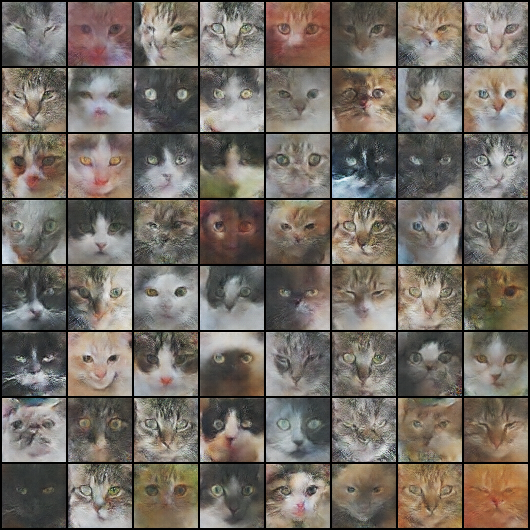

In [38]:
Image('./generated/generated-images-0100.png')

In [ ]:
!pip install pytorch-fid

In [ ]:
!python -m pytorch_fid '/content/stanford-cars-dataset/cars_train/cars_train' '/content/generated' --device cuda:0 --dims 64

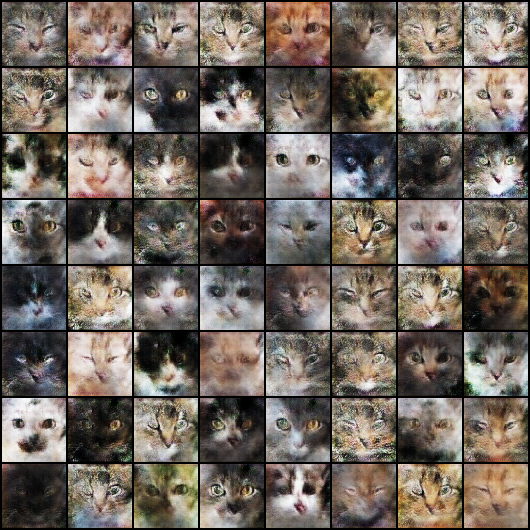

In [39]:
Image('./generated/generated-images-0025.png')

In [40]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

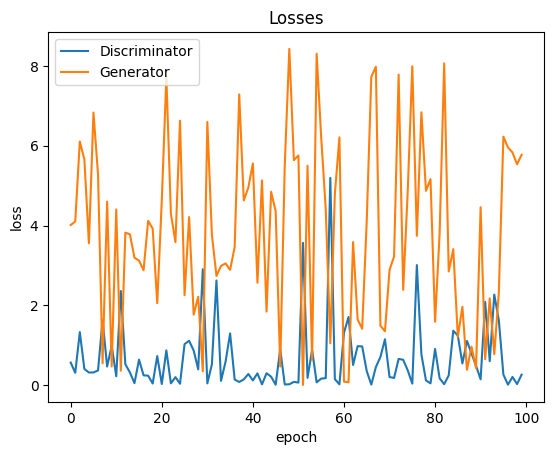

In [41]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

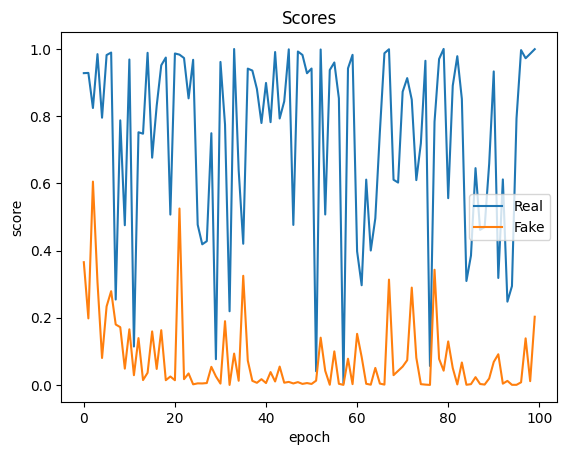

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [43]:
generator.load_state_dict(torch.load('G.pth'))
discriminator.load_state_dict(torch.load('D.pth'))

generator = to_device(generator, device)
discriminator = to_device(discriminator, device)


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
!cp G.pth '/content/drive/MyDrive/G.pth'
!cp D.pth '/content/drive/MyDrive/D.pth'

In [ ]:
!pip install pytorch_fid

In [ ]:
import torch
from torch.autograd import Variable
import numpy as np

def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=False, num_workers=4)
    
    act = np.empty((len(images), dims))

    if cuda:
        model = model.cuda()

    def hook(module, input, output):
        nonlocal act
        act = output.cpu().data.numpy().reshape(output.size(0), -1)

    hook_handle = model.fc.register_forward_hook(hook)

    for batch in dataloader:
        if cuda:
            batch = batch.cuda()
        with torch.no_grad():
            _ = model(batch)

    hook_handle.remove()

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is:
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 
    assert sigma1.shape == sigma2.shape, 

    diff = mu1 - mu2

    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset).dot(sigma2 + offset), disp=False)

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f"Imaginary component {m}")

        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)



Calculation of FID and IS 

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
from scipy.stats import entropy
import numpy as np
from tqdm import tqdm
from PIL import Image

torch.manual_seed(42)

def calculate_fid(real_images, fake_images, model, batch_size=128, dims=2048, cuda=False):
    mu1, sigma1 = calculate_activation_statistics(real_images, model, batch_size, dims, cuda)
    mu2, sigma2 = calculate_activation_statistics(fake_images, model, batch_size, dims, cuda)
    fid_value = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_value

# Function to  Inception Score (IS)
def calculate_inception_score(images, model, batch_size=128, splits=10, cuda=False):
    model.eval()
    dataloader = DataLoader(images, batch_size=batch_size, shuffle=True, num_workers=4)

    preds = []
    for batch in tqdm(dataloader, desc="Calculating Inception Score"):
        batch = batch[0].to(torch.device("cuda" if cuda else "cpu"))
        pred = model(batch)
        preds.append(torch.nn.functional.softmax(pred, dim=1).data.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculating Inception Score
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))

    inception_score = np.mean(scores)
    return inception_score

# Function to load the InceptionV3 model
def load_inception_model():
    inception_model = inception_v3(pretrained=True, transform_input=False, aux_logits=False)
    inception_model.fc = torch.nn.Identity()  # Remove the final fully connected layer
    inception_model.eval()
    return inception_model

# Function to preprocess images for InceptionV3
def preprocess_images(images, transform):
    processed_images = []
    for img in images:
        img = Image.fromarray(img.astype('uint8'))
        img = transform(img)
        processed_images.append(img)
    return torch.stack(processed_images)


data_dir = '/content/cats-faces-64x64-for-generative-models/cats'
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
dataset = ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

inception_model = load_inception_model()


real_images, _ = next(iter(dataloader))  
fake_images = torch.randn_like(real_images)  

fid_value = calculate_fid(real_images, fake_images, inception_model, cuda=True)
print(f'Frechet Inception Distance (FID): {fid_value}')


images, _ = next(iter(dataloader))  
is_value = calculate_inception_score(images, inception_model, cuda=True)
print(f'Inception Score (IS): {is_value}')
